# COMP90086 Final Project: Stereo Disparity

### Gropu members
**Student 1:** ` Yu-Hsien, Chiang (1283355)`  

**Student 2:** ` Thomas Chen (1290641)`

## Libraries

In [1]:
# Import libraries
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np                          
import cv2                  

## Image Data Preprocess

<Figure size 1000x1400 with 0 Axes>

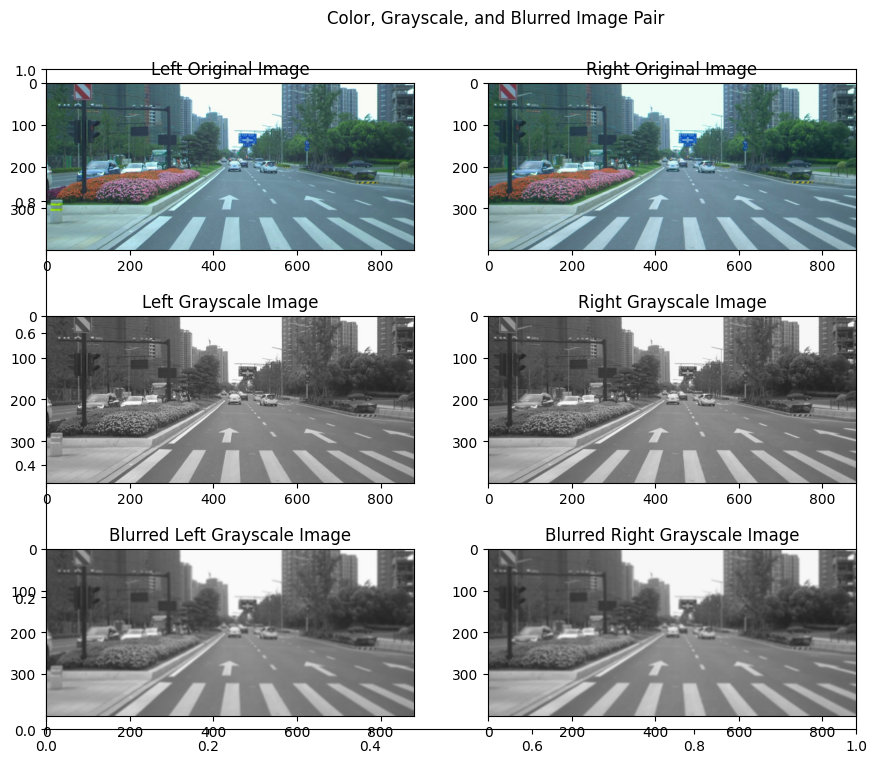

In [2]:
# Load image
ROOTPATH = "./Dataset"

class ImagePath():
    
    def __init__(self, disparity_img_paths):
        self.disparity_img_path = disparity_img_paths
        self.left_img_path = disparity_img_paths.replace("-disparity.png", "-left.jpg")
        self.right_img_path = disparity_img_paths.replace("-disparity.png", "-right.jpg")
        
    def __str__(self) -> str:
        return self.disparity_img_path.replace("-disparity.png", "")
    
    def __eq__(self, other: object) -> bool:
        return str(self) == str(other)


image_name = "2018-07-09-16-11-56_2018-07-09-16-13-38-366"
sample_img = ImagePath(os.path.join(ROOTPATH, image_name + "-disparity.png"))    



# Load left and right images pair
img_L = cv2.imread(sample_img.left_img_path, cv2.IMREAD_COLOR)
img_R = cv2.imread(sample_img.right_img_path, cv2.IMREAD_COLOR)

# Load ground truth image 
img_tru = cv2.imread(sample_img.disparity_img_path, -1)

# Convert image to gray-scale
img_L_gray = cv2.cvtColor(img_L, cv2.COLOR_BGR2GRAY)
img_R_gray = cv2.cvtColor(img_R, cv2.COLOR_BGR2GRAY)

# Blur image to reduce noises
img_L_gray_blur = cv2.GaussianBlur(img_L_gray, ksize=[7,7], sigmaX=2, sigmaY=2)
img_R_gray_blur = cv2.GaussianBlur(img_R_gray, ksize=[7,7], sigmaX=2, sigmaY=2)

plt.figure(figsize=(10,14))
plt.subplots(figsize=(12,6))
plt.subplots_adjust(bottom=0.1, right=0.8, top=1.2)
plt.subplot(3,2,1, title="Left Original Image")
plt.imshow(cv2.cvtColor(img_L, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,2, title="Right Original Image")
plt.imshow(cv2.cvtColor(img_R, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,3, title="Left Grayscale Image")
plt.imshow(cv2.cvtColor(img_L_gray, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,4, title="Right Grayscale Image")
plt.imshow(cv2.cvtColor(img_R_gray, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,5, title="Blurred Left Grayscale Image")
plt.imshow(cv2.cvtColor(img_L_gray_blur, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,6, title="Blurred Right Grayscale Image")
plt.imshow(cv2.cvtColor(img_R_gray_blur, cv2.COLOR_BGR2RGB))
plt.suptitle("Color, Grayscale, and Blurred Image Pair", y=1.3)
plt.show()

## Normalised Cross Correlation

In [3]:
class MatchCost():
    def __init__(self, img_L, img_R):
        self.img_L = img_L
        self.img_R = img_R
    
    def compute(self, disparity_level=5, window_size=3):
        """Compute the matching cost usinng normalised cross correlation method

        Args:
            disparity_level (int, optional):
                The maximum disparity to search. Defaults to 5.
            window_size (int, optional):
                The width of the square matching window. The value should be an odd integer. Defaults to 3.

        Returns:
            disparity_map (float, numpy.ndarray, shape(H, W)):
                A matrix of disparity values of each pixel in the image
            cost_map (float, numpy.ndarray, shape(H, W, disparity_level+1)):
                The cost value for each position (height, width, disparity)
        """
        
        # start timing
        start = time.time()
        
        # Initialise parameters
        H, W = self.img_L.shape
        disparity_level += 1
        # the radius of the window
        half_window_size = window_size // 2        
        cost_map = np.zeros((H, W, disparity_level), dtype=np.float64)
        
        # loop through image
        for h in tqdm(range(half_window_size, H-half_window_size, 1)):
            
            for w in range(half_window_size+ disparity_level, W-half_window_size, 1):
                
                # loop through disparity
                for d in range(disparity_level):
                    
                    # cost_map[h, w, d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w+disparity_level-d), window_size=window_size)
                     if w-half_window_size-d >= 0:
                         cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w - d), window_size=window_size)
                     else:
                         # if the matching position in img_R is out of bound, match the left position with the most left pixel in img_R
                         cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, 0), window_size=window_size)
        
        # Estimate the most left section's cost values with the cost values at the most right section 
        # for w in range(half_window_size, disparity_level+1):
        #      cost_map[:, w, :] += cost_map[:, W-1-w, :] * 0.4
        
        self.cost_map = cost_map
        self.disparity_map = np.argmin(cost_map, axis=2)
        
        # Recoard function runtime
        end = time.time()
        self.runtime = end-start
        
        return self.disparity_map, self.cost_map
    
    
    def normalise_cross_correlate(self, p_L, p_R, window_size):
        """Calculate the normalised cross correlation of the two windows
           in img_L and img_R at the position of p_L and p_R

        Args:
            p_L ((int, int)):
                The cooridinate of the window center at img_L. 
                The first element is the height, the second element is the widths
            p_R ((int, int)):
                the cooridinate of the window center at img_R. 
                The first element is the height, the second element is the widths
            window_size (int, odd number):
                The dimension of the square window.  The value should be an odd integer

        Returns:
            normalised_cross_correlation (float):
                The normalised cross correlation of the two windows
                in img_L and img_R at the position of p_L and p_R.  The value is a float >= 0
        """
        
        h_L, w_L = p_L
        h_R, w_R = p_R
        
        half_window_size = window_size // 2
        
        matrix_L = self.img_L[h_L - half_window_size : h_L + half_window_size + 1, w_L - half_window_size : w_L + half_window_size + 1]
        matrix_R = self.img_R[h_R - half_window_size : h_R + half_window_size + 1, w_R - half_window_size : w_R + half_window_size + 1]
        
        # Shift the value so that the mean of the matrix is 0
        matrix_L = matrix_L - np.mean(matrix_L)
        matrix_R = matrix_R - np.mean(matrix_R)

        # Compute the scaling factor of the matrix
        norm_L = np.linalg.norm(matrix_L)
        norm_R = np.linalg.norm(matrix_R)
        
        # return normalised cross correlation value, if the norm of either matrix is 0 and two matrices are not identical, return 0
        # if the norm of either matrix is 0 but the two matrices are identical, return 1
        if norm_L !=0 and norm_R !=0:
            cc = np.sum((matrix_L * matrix_R))
            ncc = cc / (norm_L * norm_R)
        elif np.array_equal(matrix_L, matrix_R):
            ncc = 1
        else:
            ncc = 0
        
        return ncc

In [4]:
# Compute cost value using normalised cross correlation

match_cost = MatchCost(img_L=img_L_gray_blur, img_R=img_R_gray_blur)
disparity_map_NCC, cost_map_NCC = match_cost.compute(disparity_level=80, window_size=7)
runtime_NCC = match_cost.runtime

100%|██████████| 394/394 [07:27<00:00,  1.14s/it]


## Semi-Global Matching

In [5]:
class SGM():
    
    def __init__(self, p1, p2, cost_map=None):
        if cost_map is not None:
            self.cost_map = cost_map
        self.p1 = p1
        self.p2 = p2
    
    def compute(self, cost_map=None):
        """Implementing semi-global matching algorithm to compute the smoothed cost value for a given cost volum matrix

        Args:
            cost_map (float, numpy.ndarray, shape(H, W, disparity_level)): 
                The cost map can be the result of any matching algorithm . Defaults to None.

        Returns:
            disparity_map (float, numpy.ndarray, shape(H, W)):
                A matrix of disparity values of each pixel in the image
            energy_matrix (float, numpy.ndarray, shape(H, W, disparity_level+1)):
                The cost value for each position (height, width, disparity)
        """
        
        # start timinng
        start = time.time()
        
        if cost_map is not None:
            self.cost_map = cost_map
        
        # Initialise parameters
        H, W, D = self.cost_map.shape
        E_init = np.zeros((H, W, D))
        E_init[0, :, :] = self.cost_map[0, :, :]
        E_init[H-1, :, :] = self.cost_map[H-1, :, :]
        E_init[:, 0, :] = self.cost_map[:, 0, :]
        E_init[:, W-1, :] = self.cost_map[:, W-1, :]
        
        # Left to Right scan
        #L2R
        E_a1 = np.copy(E_init)
        E_a1[:, 1:W] = 0
        
        #TL2BR
        E_a5 = np.copy(E_init)
        E_a5[1:H, 1:W] = 0
        
        #BL2TR
        E_a8 = np.copy(E_init)
        E_a8[0:H-1, 1:W] = 0
        
        for w in range(1, W):
            E_a1[:, w, :] = self.cost_map[:, w, :] + self.cost_arggregate(E_pre=E_a1[:, w-1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.cost_arggregate(E_pre=E_a5[:, w-1, :])[0: H-1, :]
            E_a5[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] = c_m[0:H-1, :] + self.cost_arggregate(E_pre=E_a8[:, w-1, :])[1:H, :]
            E_a8[:, w, :] = c_m
        
        
        # Right to Left scan
        #R2L
        E_a2 = np.copy(E_init)
        E_a2[:, 0:W-1] = 0
        
        #TR2BL
        E_a6 = np.copy(E_init)
        E_a6[1:H, 0:W-1] = 0
        
        #BR2TL
        E_a7 = np.copy(E_init)
        E_a7[0:H-1, 0:W-1] = 0
        
        for w in range(W-2, -1, -1):
            E_a2[:, w, :] = self.cost_map[:, w, :] + self.cost_arggregate(E_pre=E_a2[:, w+1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.cost_arggregate(E_pre=E_a6[:, w+1, :])[0:H-1, :]
            E_a6[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] =c_m[0:H-1, :] + self.cost_arggregate(E_pre=E_a7[:, w+1, :])[1:H, :]
            E_a7[:, w, :] = c_m
        
        
        # Top to Bottom scan
        #T2B
        E_a3 = np.copy(E_init)
        E_a3[1:H, :] = 0
        for h in range(1, H):
            E_a3[h, :, :] = self.cost_map[h, :, :] + self.cost_arggregate(E_pre=E_a3[h-1, :, :])
                    
        # Bottom to Top scan
        #B2T
        E_a4 = np.copy(E_init)
        E_a4[0:H-1, :] = 0
        for h in range(H-2, -1, -1):
            E_a4[h, :, :] = self.cost_map[h, :, :] + self.cost_arggregate(E_pre=E_a4[h+1, :, :])
           
        # Aggregate teh costs    
        E = np.array(E_a1 + E_a2 + E_a3 + E_a4 + (E_a5 + E_a6 + E_a7 + E_a8)*2.0, dtype=np.int32)
        
        self.energy_matrix = E
        self.disparity_map = np.argmin(E, axis=2)
        
        # Recoard function runtime
        end = time.time()
        self.runtime = end - start
        
        return self.disparity_map, self.energy_matrix
    
    
    def cost_arggregate(self, E_pre):
        """Computing the aggregated cost value of a specific H or W position

        Args:
            E_pre (float, numpy.ndarray, shape(R, disparity_level+1)): 
                The cost values of the previous position

        Returns:
            aggregate_cost_map (float, numpy.ndarray, shape(R, disparity_level+1)):
                The aggregated cost value map
        """
        
        R, D = E_pre.shape
        
        # Shifting the array along the disarpity axis in positive direction
        d_plus = np.full((R,D), np.inf)
        d_plus[:, 1:D] = E_pre[:, 0:D-1] + self.p1
        
        # Shifting the array along the disarpity axis in negative direction
        d_minus = np.full((R,D), np.inf)
        d_minus[:, 0:D-1] = E_pre[:, 1:D] + self.p1
        
        # Find the minimum cost value along the disparity axis
        d_min = np.repeat([np.amin(E_pre, axis=1)], D, axis=0).T + self.p2
        
        return np.amin([E_pre, d_plus, d_minus, d_min], axis=0) - (d_min - self.p2)

In [6]:
# Compute smoothed cost value using SGM

sgm = SGM(p1=0.007, p2=0.03, cost_map=cost_map_NCC)
disparity_map_SGM, energy_matrix_SGM = sgm.compute()
runtime_SGM = sgm.runtime

## Analysis

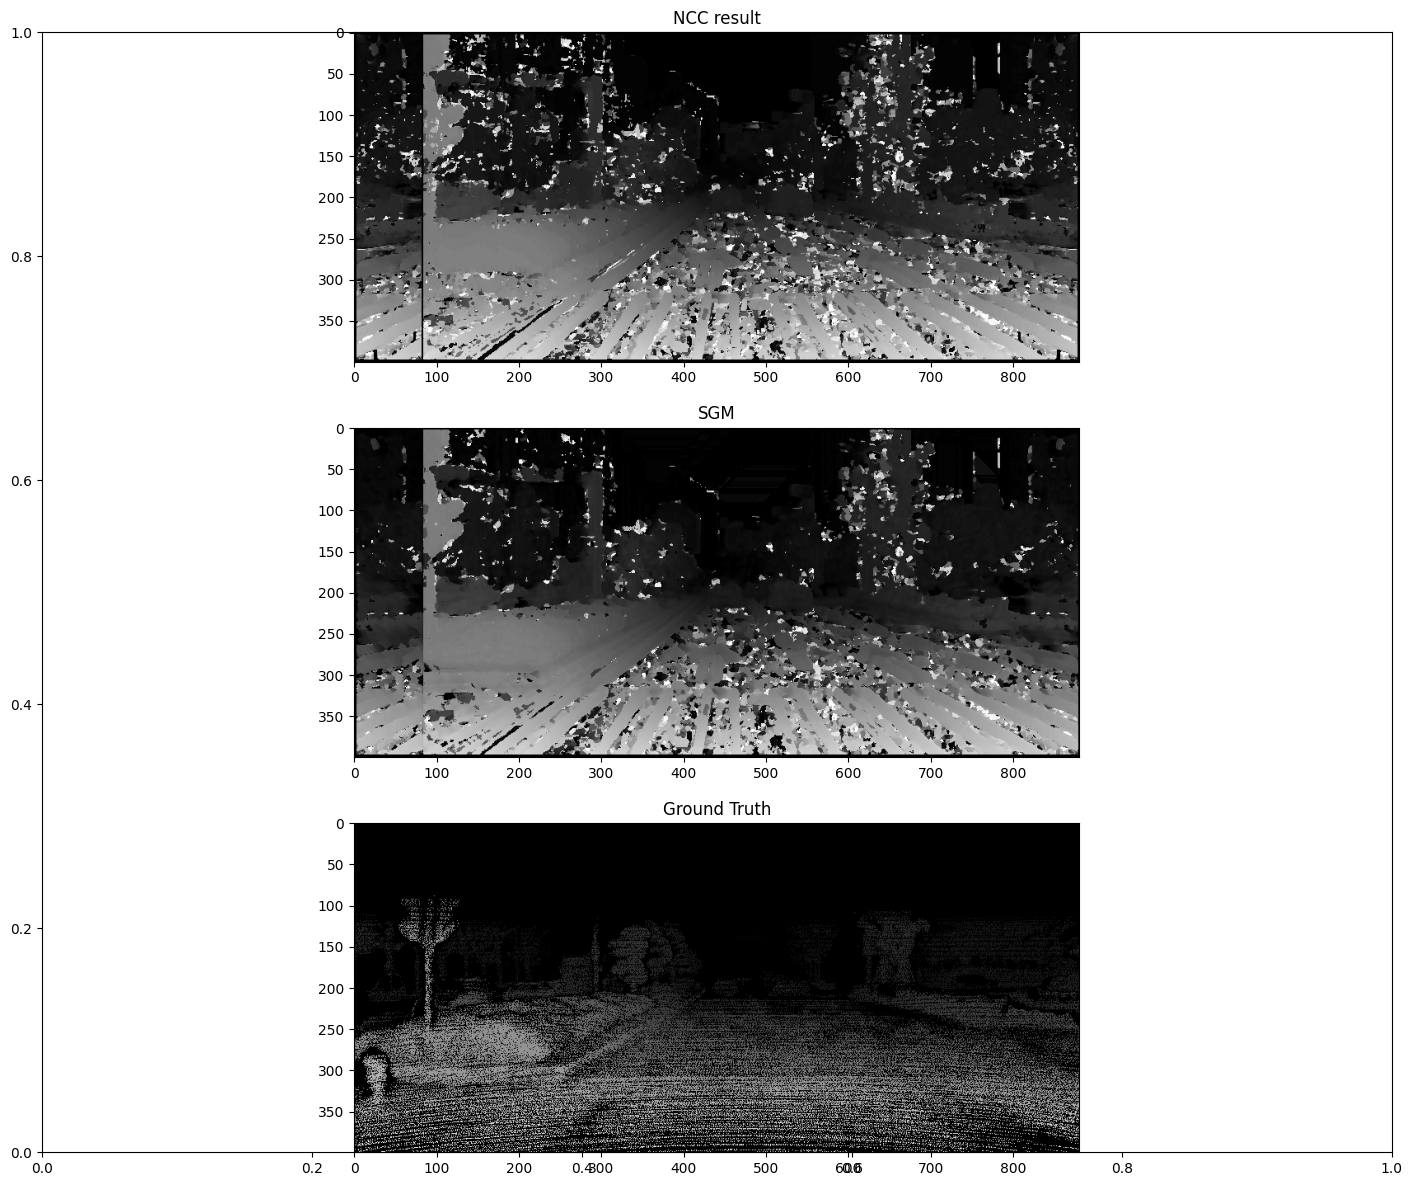

In [7]:
# Showing the result disparity image 

disparity_img_NCC = (disparity_map_NCC/np.max(disparity_map_NCC)) * 255
disparity_img_SGM = (disparity_map_SGM/np.max(disparity_map_SGM)) * 255

plt.subplots(figsize=(20, 8))
plt.subplots_adjust(bottom=0.1, right=0.8, top=1.5)
plt.subplot(3,1,1, title="NCC result")
plt.imshow(disparity_img_NCC, cmap='gray')
plt.subplot(3,1,2, title="SGM")
plt.imshow(disparity_img_SGM, cmap='gray')
plt.subplot(3,1,3, title="Ground Truth")
plt.imshow(img_tru, cmap='gray')

plt.show()

In [8]:
# Root mean square error analysis

disparity_true = img_tru / 256
H, W = disparity_true.shape

error_map_NCC = np.full(shape=(H,W), fill_value=np.nan)
error_map_SGM = np.full(shape=(H,W), fill_value=np.nan)

count=0
for h in range(H):
    for w in range(W):
        if disparity_true[h,w] != 0:
            error_map_NCC[h,w] = abs(disparity_map_NCC[h,w] - disparity_true[h,w])
            error_map_SGM[h,w] = abs(disparity_map_SGM[h,w] - disparity_true[h,w])
            count += 1

rmse_NCC = np.sqrt(np.nansum(np.square(error_map_NCC)) / count)
rmse_SGM = np.sqrt(np.nansum(np.square(error_map_SGM)) / count)

print(f"NCC Root mean square error: {round(rmse_NCC, 4)}")
print(f"SGM Root mean square error: {round(rmse_SGM, 4)}")

NCC Root mean square error: 14.2009
SGM Root mean square error: 13.1214


In [9]:
# Fraction of pixel errors analysis

error_pixel_NCC_count_4 = np.count_nonzero(error_map_NCC < 4)
error_pixel_NCC_count_2 = np.count_nonzero(error_map_NCC < 2)
error_pixel_NCC_count_1 = np.count_nonzero(error_map_NCC < 1)
error_pixel_NCC_count_05 = np.count_nonzero(error_map_NCC < 0.5)
error_pixel_NCC_count_025 = np.count_nonzero(error_map_NCC < 0.25)

error_pixel_SGM_count_4 = np.count_nonzero(error_map_SGM < 4)
error_pixel_SGM_count_2 = np.count_nonzero(error_map_SGM < 2)
error_pixel_SGM_count_1 = np.count_nonzero(error_map_SGM < 1)
error_pixel_SGM_count_05 = np.count_nonzero(error_map_SGM < 0.5)
error_pixel_NCC_count_025 = np.count_nonzero(error_map_NCC < 0.25)

print(f"Comparing point count: {count}\n")
print(f"===========\n    NCC    \n===========")
print(f"Fraction of pixels error < 4:      {round(error_pixel_NCC_count_4/count, 4)}")
print(f"Fraction of pixels error < 2:      {round(error_pixel_NCC_count_2/count, 4)}")
print(f"Fraction of pixels error < 1:      {round(error_pixel_NCC_count_1/count, 4)}")
print(f"Fraction of pixels error < 0.5:    {round(error_pixel_NCC_count_05/count, 4)}")
print(f"Fraction of pixels error < 0.25:   {round(error_pixel_NCC_count_025/count, 4)}")
print()
print(f"===========\n    SGM    \n===========")
print(f"Fraction of pixels error < 4:      {round(error_pixel_SGM_count_4/count, 4)}")
print(f"Fraction of pixels error < 2:      {round(error_pixel_SGM_count_2/count, 4)}")
print(f"Fraction of pixels error < 1:      {round(error_pixel_SGM_count_1/count, 4)}")
print(f"Fraction of pixels error < 0.5:    {round(error_pixel_SGM_count_05/count, 4)}")
print(f"Fraction of pixels error < 0.25:   {round(error_pixel_NCC_count_025/count, 4)}")

Comparing point count: 90029

    NCC    
Fraction of pixels error < 4:      0.7206
Fraction of pixels error < 2:      0.6133
Fraction of pixels error < 1:      0.4432
Fraction of pixels error < 0.5:    0.2592
Fraction of pixels error < 0.25:   0.1238

    SGM    
Fraction of pixels error < 4:      0.7253
Fraction of pixels error < 2:      0.5793
Fraction of pixels error < 1:      0.3697
Fraction of pixels error < 0.5:    0.2052
Fraction of pixels error < 0.25:   0.1238


In [10]:
# Algorithm Runtime
print(f"Runtime of NCC algorithm:   {round(runtime_NCC, 4)} (s)")
print(f"Runtime of SGM algorithm:   {round(runtime_SGM, 4)} (s)")

Runtime of NCC algorithm:   447.5363 (s)
Runtime of SGM algorithm:   3.6303 (s)
